<a href="https://colab.research.google.com/github/Andy-jorg/Image_dataset_for_Pretest/blob/main/Pr%C3%A6test_modellering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we install ktrain, load some packages and clone our repository with the necessary data

In [ ]:
!pip install ktrain

In [ ]:
%matplotlib inline
import os
import ktrain
from ktrain import vision as vis
import pandas as pd
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's see if the cloning works and we can see some pictures

In [ ]:
vis.show_random_images('/content/Image_dataset_for_Pretest/images_for_model')

Now we'll use ktrain  to set up the model.

First we start by creating a function that partitions our images into train and validation set and where we know information about our scores

In [ ]:
# Alter the code below to have the correct images folder (directory) and train and val fpath, depending on whether it is means, sample, with or without extra train set etc.

def images_from_csv():
    train_fpath = '/content/Image_dataset_for_Pretest/Images_5/images_train_sample_NEW.csv'
    val_fpath = '/content/Image_dataset_for_Pretest/Images_5/images_val_sample_NEW.csv'
    trn, val, preproc = vis.images_from_csv(
                          train_fpath,
                          'image',
                          directory='/content/Image_dataset_for_Pretest/Images_5',
                          is_regression = True,
                          val_filepath = val_fpath,
                          target_size = (224, 224),
                          label_columns = 'liking',
                          data_aug=vis.get_data_aug(horizontal_flip=True))
    return (trn, val, preproc)

In [ ]:
(train_data, val_data, preproc) = images_from_csv()

See available models

In [ ]:
vis.print_image_regression_models()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

Now we chose the model - let's try with ResNet50

In [ ]:
model = vis.image_regression_model('pretrained_resnet50',
                                   train_data = train_data,
                                   val_data = val_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
94765736/94765736 [==============================] - 0s 0us/step
pretrained_resnet50 model created.


In [ ]:
learner = ktrain.get_learner(model = model,
                             train_data = train_data,
                             val_data = val_data,
                             batch_size = 64)

learner

To find optimal learning rate run the code below. However, it is very slow.

In [ ]:
learner.lr_find(max_epochs=2)

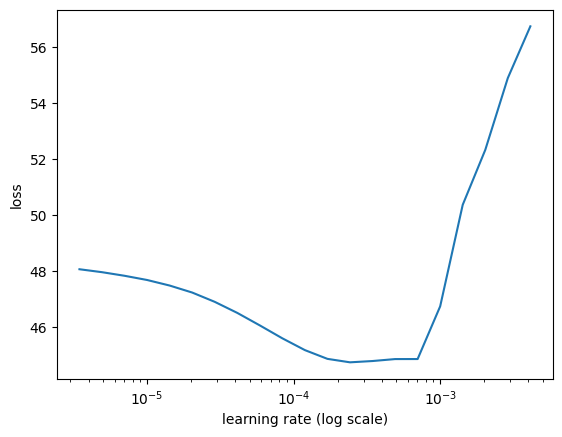

In [ ]:
learner.lr_plot()

# Training

We will begin by training the model for 7 epochs using a 1cycle (https://arxiv.org/abs/1803.09820) learning rate policy.

In [ ]:
learner.fit_onecycle(1e-4, 7)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/7
1047/1047 [==============================] - 1006s 954ms/step - loss: 9.1263 - mae: 2.3800 - val_loss: 2.3072 - val_mae: 1.2014
Epoch 2/7
1047/1047 [==============================] - 998s 953ms/step - loss: 6.0896 - mae: 1.9458 - val_loss: 1.8534 - val_mae: 1.0599
Epoch 3/7
1047/1047 [==============================] - 993s 948ms/step - loss: 4.3155 - mae: 1.6369 - val_loss: 1.6581 - val_mae: 1.0178
Epoch 4/7
1047/1047 [==============================] - 1000s 955ms/step - loss: 3.4067 - mae: 1.4537 - val_loss: 1.9220 - val_mae: 1.1129
Epoch 5/7
1047/1047 [==============================] - 1076s 1s/step - loss: 2.7773 - mae: 1.3142 - val_loss: 1.3562 - val_mae: 0.9141
Epoch 6/7
1047/1047 [==============================] - 1124s 1s/step - loss: 2.1132 - mae: 1.1452 - val_loss: 1.1768 - val_mae: 0.8382
Epoch 7/7
1047/1047 [==============================] - 1155s 1s/step - loss: 1.7141 - mae: 1.0315 - val_loss: 1.0080

Run the code below to save the learning. Remember to update the path

In [ ]:
ktrain.get_predictor(learner.model, preproc).save('/content/gdrive/MyDrive/Colab/my_predictor_50_less')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Try to load model and keep training

In [ ]:
model = ktrain.load_predictor('/content/gdrive/MyDrive/Colab/my_predictor_50_less').model

# re-instantiate Learner and continue training
learner = ktrain.get_learner(model, train_data = train_data, val_data = val_data)


Now we will freze some layers and train for another two epochs on the remaining unfreezed layers. We will freeze the first 40 layers

In [ ]:
learner.freeze(20)

learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
1047/1047 [==============================] - 1131s 1s/step - loss: 1.4408 - mae: 0.9389 - val_loss: 0.8898 - val_mae: 0.7438
Epoch 2/4
1047/1047 [==============================] - 1114s 1s/step - loss: 0.9302 - mae: 0.7525 - val_loss: 1.0482 - val_mae: 0.7925
Epoch 3/4
1047/1047 [==============================] - 1116s 1s/step - loss: 0.8845 - mae: 0.7343 - val_loss: 0.8444 - val_mae: 0.7257
Epoch 4/4
1047/1047 [==============================] - 1130s 1s/step - loss: 0.8393 - mae: 0.7158 - val_loss: 0.8344 - val_mae: 0.7150


# Prediction

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

Now we try to predict based on filenames. First we import the necessary datafiles

In [ ]:
#DATADIR = "/content/Image_dataset_for_Pretest/Images_5"

DATADIR = "/content/Image_dataset_for_Pretest/Test images"

# Create a list of image file names
image_files = [f for f in os.listdir(DATADIR) if f.endswith(('.jpg', '.jpeg', '.png'))]



In [ ]:
# Create a DataFrame to store predictions
predictions_df = pd.DataFrame(columns=['Image', 'Prediction'])


In [ ]:
# Loop through each image, make predictions, and store results in the DataFrame
for image_file in image_files:
    image_path = os.path.join(DATADIR, image_file)

   # Make prediction using the predictor
    prediction = predictor.predict_filename(image_path)

    # Append results to DataFrame
    predictions_df = predictions_df.append({'Image': image_file, 'Prediction': prediction}, ignore_index=True)


Now we save the file as a .csv file to the drive

In [ ]:
# Save the DataFrame as a CSV or Excel file
csv_filename = "/content/gdrive/MyDrive/Colab/predictions_test_images_15012024.csv"
predictions_df.to_csv(csv_filename, index=False)